<a href="https://colab.research.google.com/github/yyguo50170/dlg/blob/main/Deep_Leakage_from_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

2.0.1+cu118 0.15.2+cu118


In [61]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

def dlg_attack(gt_data,gt_onehot_label,net,original_dy_dx,epoch):
    dlg_lr = 1
    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label],lr = dlg_lr)
    loss_list = []

    history = []
    for iters in range(5000):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                #grad_diff += ((gx - gy) ** 2).sum()
                #grad_count += gx.nelement()
                cos_sim = torch.nn.functional.cosine_similarity(gx.view(-1), gy.view(-1), dim=0)

                # 累加余弦相似度和梯度元素数量
                grad_diff += (1 - cos_sim)  # Invert the similarity to get a "difference"


            grad_diff.backward()

            return grad_diff

        optimizer.step(closure)
        current_loss = closure()
        loss_list.append(current_loss.item())
        if iters % 10 == 0:
            print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))
        #if current_loss.item() < 0.0001:
        #  print("global epoch:{}, converge dlg iters:{}".format(epoch,iters))
        #  break
    plt.figure()
    plt.imshow(history[-1])
    plt.title("Final dummy data")
    plt.show()

    print(loss_list)
    plt.figure()
    plt.plot(range(len(loss_list)), loss_list, label='dlg loss')
    plt.title('the loss of dlg task epoch:{}'.format(epoch))
    plt.xlabel('dlg epoch')
    plt.ylabel('loss')
    loss_path = './drive/My Drive/result/dlg_loss/epoch{}_lr{}_cos.jpg'.format(epoch,dlg_lr)
    plt.savefig(loss_path)

    #plt.show()
    plt.figure(figsize=(12, 8))
    for i in range(500):
      plt.subplot(50, 10, i + 1)
      plt.imshow(history[i * 10])
      plt.title("iter=%d" % (i * 10))
      plt.axis('off')
    #plt.savefig('/content/dlg_cifar100_epoch{}.png'.format(epoch))
    plt.show()
    print("Final dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Files already downloaded and verified
Running on cuda


In [62]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

Files already downloaded and verified
GT label is 84. 
Onehot label is 84.


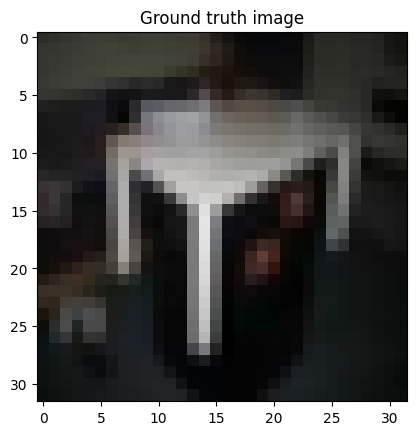

In [63]:
######### honest partipant #########

# Hyper-parameters
epochs = 160
local_eoochs = 1
batch_size = 64
learning_rate = 0.001

train_dataset = datasets.CIFAR100(root='./torch', train=True, transform=tp, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_criterion = nn.CrossEntropyLoss()
train_optimizer = optim.Adam(net.parameters(), lr=learning_rate)


#攻击用数据
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())


In [64]:
# for i in range(epochs):
#   if i not in[2,50,100,150,200]:
#     # Train the model
#     total_step = len(train_loader)
#     for local_epoch in range(local_eoochs):
#       for j, (images, labels) in enumerate(train_loader):
#           images = images.to(device)
#           labels = labels.to(device)

#           # Forward pass
#           outputs = net(images)
#           loss = train_criterion(outputs, labels)

#           # Backward and optimize
#           train_optimizer.zero_grad()
#           loss.backward()
#           train_optimizer.step()

#           if (j+1) % 700 == 0:
#               print ('epoch:{}   Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(i+1,local_epoch+1, local_eoochs, j+1, total_step, loss.item()))
#     if i in[0,49,99,149,199]:
#       model_path = './drive/My Drive/result/model_dict/epoch_{}.pth'.format(i)
#       torch.save(net.state_dict(), model_path)

#   else:

#     # compute original gradient
#     out = net(gt_data)
#     y = criterion(out, gt_onehot_label)
#     dy_dx = torch.autograd.grad(y, net.parameters())


#     # share the gradients with other clients
#     original_dy_dx = list((_.detach().clone() for _ in dy_dx))
#     print('dlg epoch:',i+1)
#     dlg_attack(gt_data,gt_onehot_label,net,original_dy_dx,i)
#     for server_param, grad_param in zip(net.parameters(), dy_dx):
#       server_param.data = server_param.data - learning_rate * grad_param.data.clone()


dlg epoch: 50
Dummy label is 64.
0 2.4261
10 1.0261
20 0.8795
30 0.7689
40 0.6843
50 0.6107
60 0.5342
70 0.4827
80 0.4413
90 0.4062
100 0.3844
110 0.3662
120 0.3374
130 0.3156
140 0.2985
150 0.2836
160 0.2712
170 0.2609
180 0.2508
190 0.2428
200 0.2350
210 0.2278
220 0.2211
230 0.2140
240 0.2076
250 0.2033
260 0.1980
270 0.1936
280 0.1903
290 0.1874
300 0.1843
310 0.1812
320 0.1779
330 0.1755
340 0.1730
350 0.1708
360 0.1689
370 0.1666
380 0.1643
390 0.1608
400 0.1582
410 0.1559
420 0.1539
430 0.1522
440 0.1505
450 0.1490
460 0.1479
470 0.1465
480 0.1453
490 0.1441
500 0.1431
510 0.1416
520 0.1401
530 0.1386
540 0.1373
550 0.1359
560 0.1348
570 0.1336
580 0.1327
590 0.1315
600 0.1303
610 0.1292
620 0.1283
630 0.1275
640 0.1268
650 0.1262
660 0.1256
670 0.1251
680 0.1246
690 0.1241
700 0.1237
710 0.1233
720 0.1229
730 0.1226
740 0.1223
750 0.1219
760 0.1215
770 0.1211
780 0.1208
790 0.1205
800 0.1202
810 0.1198
820 0.1195
830 0.1191
840 0.1188
850 0.1185
860 0.1180
870 0.1176
880 0.1169

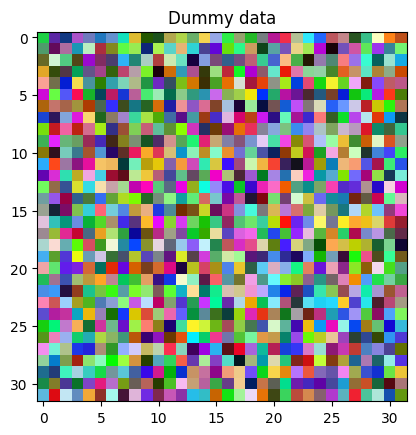

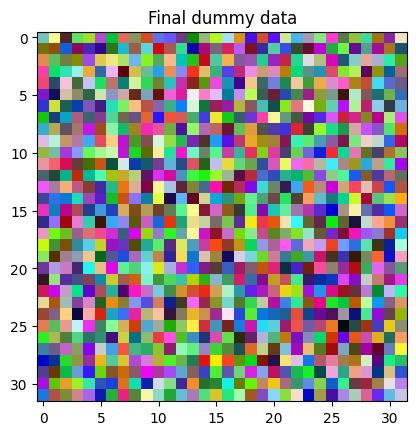

[2.4260566234588623, 1.5833345651626587, 1.4029834270477295, 1.3216681480407715, 1.2537750005722046, 1.2042441368103027, 1.1650166511535645, 1.1249539852142334, 1.095231056213379, 1.0555973052978516, 1.0261256694793701, 1.0025084018707275, 0.9869324564933777, 0.9737762808799744, 0.9606480002403259, 0.9469802379608154, 0.9354037642478943, 0.9225729703903198, 0.9078375101089478, 0.8923441171646118, 0.8794925808906555, 0.8665873408317566, 0.856483519077301, 0.8480342030525208, 0.8371373414993286, 0.8266032934188843, 0.8156645894050598, 0.7997565865516663, 0.7886446118354797, 0.7784906029701233, 0.7688678503036499, 0.7619104981422424, 0.7509198188781738, 0.7422335147857666, 0.7332634925842285, 0.7261599898338318, 0.7185455560684204, 0.7102038264274597, 0.7005109190940857, 0.6917750239372253, 0.6843412518501282, 0.6765267252922058, 0.6687997579574585, 0.6604573726654053, 0.6527230143547058, 0.6449464559555054, 0.6369845271110535, 0.6280727982521057, 0.6206578612327576, 0.6154375076293945, 0

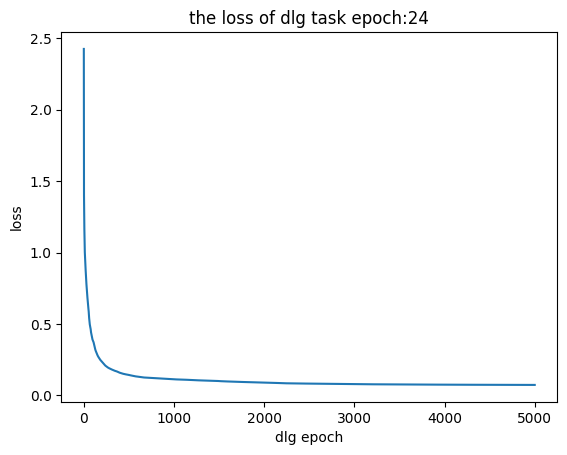

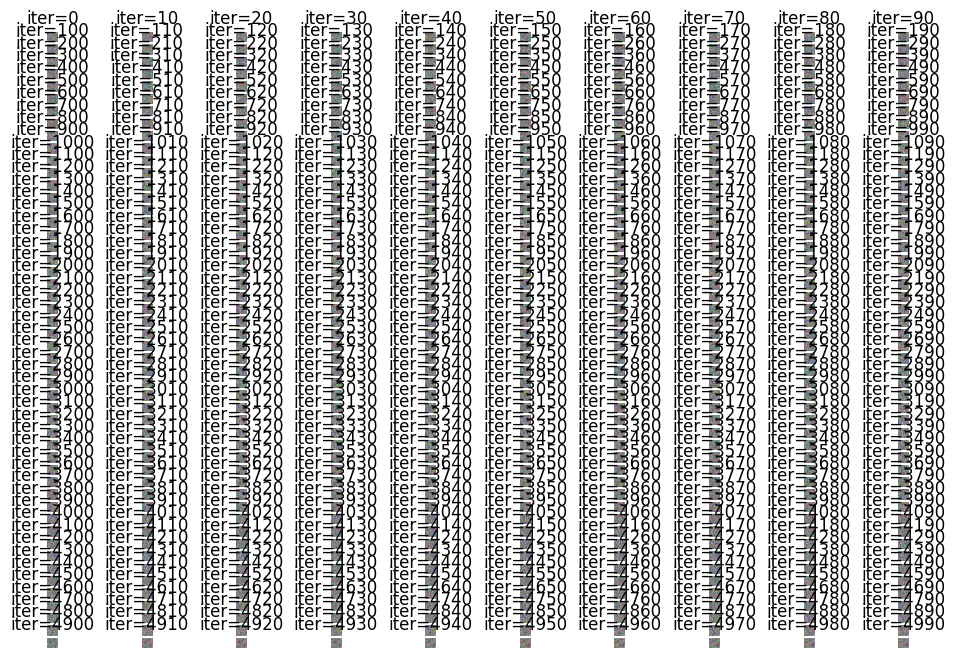

Final dummy label is 84.


In [65]:
net.load_state_dict(torch.load('/content/drive/MyDrive/result/model_dict/epoch_49.pth'))
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))
print('dlg epoch:',50)
dlg_attack(gt_data,gt_onehot_label,net,original_dy_dx,i)
